SEE https://discuss.pytorch.org/t/differentiable-torch-histc/25865/2
AS A POSSIBILITY

In [274]:
!pip install fast-histogram

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 1.5 MB/s 


In [279]:
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

from fast_histogram import histogram1d

In [378]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    #encoding
    self.c1 = nn.Conv2d(3,50,3,2)
    self.c2 = nn.Conv2d(50,50,3,2,2)
    self.c3 = nn.Conv2d(50,50,3,1)

    self.dc1 = nn.ConvTranspose2d(50,50,3,2)
    self.dc2 = nn.ConvTranspose2d(50,50,4,2)
    self.dc3 = nn.ConvTranspose2d(50,3,3,1,padding=1)

  def forward(self,x):
    x = self.c1(x)
    x = nn.functional.relu(x)
    x = self.c2(x)
    x = nn.functional.relu(x)
    x = self.c3(x)
    x = nn.functional.relu(x)

    x = self.dc1(x)
    x = nn.functional.relu(x)
    x = self.dc2(x)
    x = nn.functional.relu(x)
    x = self.dc3(x)
    x = nn.functional.sigmoid(x)
    return x

In [3]:
model = AutoEncoder().to("cuda:0")

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 50, 127, 127]           1,400
            Conv2d-2           [-1, 50, 65, 65]          22,550
            Conv2d-3           [-1, 50, 63, 63]          22,550
   ConvTranspose2d-4         [-1, 50, 127, 127]          22,550
   ConvTranspose2d-5         [-1, 50, 256, 256]          40,050
   ConvTranspose2d-6          [-1, 3, 256, 256]           1,353
Total params: 110,453
Trainable params: 110,453
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 41.93
Params size (MB): 0.42
Estimated Total Size (MB): 43.10
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


HistNET

In [427]:
class HistNet(nn.Module):
  def __init__(self,img_size):
    super().__init__()
    #takes in just the hue channel, normalized to [0,256[ range.
    self.in_size = img_size * img_size
    #                                                                   3 milions de paramètres pour rien -- changer en conv pour la réduction
    self.c1 = nn.Linear(self.in_size,540)
    self.c2 = nn.Linear(540,256)
    
  def forward(self,x):
    x = torch.reshape(x,(-1,self.in_size))
    x = self.c1(x)
    x = nn.Dropout(0.3)(x)
    x = nn.functional.relu(x)
    x = self.c2(x)
    x = nn.Dropout(0.3)(x)
    #                                                                     essayer avec Softmax
    x = nn.ReLU()(x)
    return x

In [57]:
model = HistNet(256).to("cuda:0")

summary(model, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 540]      35,389,980
            Linear-2                  [-1, 256]         138,496
Total params: 35,528,476
Trainable params: 35,528,476
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.01
Params size (MB): 135.53
Estimated Total Size (MB): 135.79
----------------------------------------------------------------


In [ ]:
def make_histogram(img_h):
  hist = histogram1d(np.array(img_h),bins=256,range=[0,256])/torch.numel(img)
  return torch.Tensor(hist)

#image is a (3,_,_) tensor
def plot_histogram_comparison(hist_model,image):
  histImg = np.array(make_histogram(image))*256
  histPred = np.array(hist_model(image.to("cuda:0")).detach().cpu())

  histPred = histPred.reshape((np.size(histPred),))

  plt.figure(figsize=(10,6))
  plt.suptitle("image histogram and generated histogram",fontsize=25)
  plt.subplot(1,2,1)
  plt.title("true histogram")
  plt.bar(list(range(256)), histImg, align='center')
  plt.subplot(1,2,2)
  plt.title("predicted histogram")
  plt.bar(list(range(256)), histPred, align='center')
  plt.show()

In [436]:
def noise_image():
  return torch.Tensor(np.random.rand(256*256*3).reshape((3,256,256)))*256.

In [437]:
def create_AE_model():
  model = AutoEncoder().to("cuda:0")
  loss = nn.MSELoss()
  opt = torch.optim.Adam(model.parameters(),lr=0.02)
  return model,loss,opt

def create_Hist_model(img_size):
  model = HistNet(img_size).to("cuda:0")
  loss = nn.MSELoss()
  opt = torch.optim.Adam(model.parameters(),lr=0.000001)
  return model,loss,opt

In [471]:
def torch_gaussian_image(mean,variance):
  img = (torch.randn(256*256)*variance)+mean
  #img += torch.rand(256*256)*(torch.numel(img)/10)
  img = img.reshape((256,256))
  return img

did 100
torch.Size([256, 256])
means of generated histogram :  [279.37543]


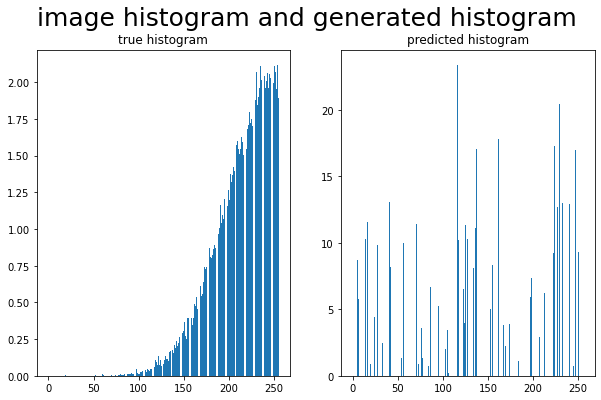

In [472]:
#plot_histogram_comparison(model,torch_gaussian_image(250,2))
for i in range(100):
  img=torch_gaussian_image(250,50)
  hist = make_histogram(img)
  img = img.to("cuda:0")

print("did 100")

print(img.shape)

plot_histogram_comparison(model,img.cpu())

In [488]:
def train_histmodel(model,batch_size,nb_epochs,mean,variance):
  nb_images=500
  means=np.random.randint(0,256,batch_size)
  print(means)
  minibatches_X = [torch.stack([torch_gaussian_image(means[0],variance) for i in range(batch_size)]) for l in range(0,nb_images,batch_size)]
  minibatches_y = [torch.stack([make_histogram(img).to("cuda:0")*256. for img in batch]) for batch in minibatches_X]

  minibatches_X = [torch.stack([img.to("cuda:0") for i in range(batch_size)]) for l in range(len(minibatches_X))]
  
  test_means = [torch.dot(batch_y.cpu()[0]/256.,torch.tensor(list(range(256))).float()) for batch_y in minibatches_y]

  print("means in training data : ",test_means)

  minibatches = list(zip(minibatches_X,minibatches_y))

  for i in range(nb_epochs):
    print("epoch",i)
    for batch,target in minibatches:
      pred = model(batch)
      
      #print(pred)

      l = loss(pred,target)

      opt.zero_grad()
      l.backward()
      #optimizer step
      opt.step()

    test_image = torch_gaussian_image(means[0],variance)
    print(test_image)
    plot_histogram_comparison(model,test_image)
    test_means = [torch.dot(batch_y.cpu(),torch.tensor(list(range(256))).float())/256. for batch_y in pred]
    target = make_histogram(test_image).to("cuda:0")*256.
    print("pred1 : \n",pred)
    pred = model(test_image.to("cuda:0"))
    print("pred2 : \n",pred)

    l=loss(pred,target)

    print("loss : ",l)
    print("means of generated histograms : ",test_means)

[32]
means in training data :  [tensor(39.5250), tensor(39.6311), tensor(39.7047), tensor(39.6109), tensor(39.4509), tensor(39.5698), tensor(40.0058), tensor(39.6323), tensor(39.3790), tensor(39.4576), tensor(39.3627), tensor(39.5785), tensor(39.2649), tensor(39.7937), tensor(39.4310), tensor(39.6042), tensor(39.6052), tensor(39.3654), tensor(39.4270), tensor(39.7354), tensor(39.4439), tensor(39.4034), tensor(39.4654), tensor(39.6796), tensor(39.4571), tensor(39.4694), tensor(39.4505), tensor(39.7722), tensor(39.7578), tensor(39.5698), tensor(39.7686), tensor(39.2658), tensor(39.7998), tensor(39.4451), tensor(39.7419), tensor(39.4310), tensor(39.7040), tensor(39.4267), tensor(39.5105), tensor(39.4027), tensor(39.5678), tensor(39.6507), tensor(39.3667), tensor(39.3559), tensor(39.4979), tensor(39.6370), tensor(39.5370), tensor(39.7138), tensor(39.4491), tensor(39.8464), tensor(39.4367), tensor(39.8303), tensor(39.4549), tensor(39.4726), tensor(39.4709), tensor(39.5979), tensor(39.3077),

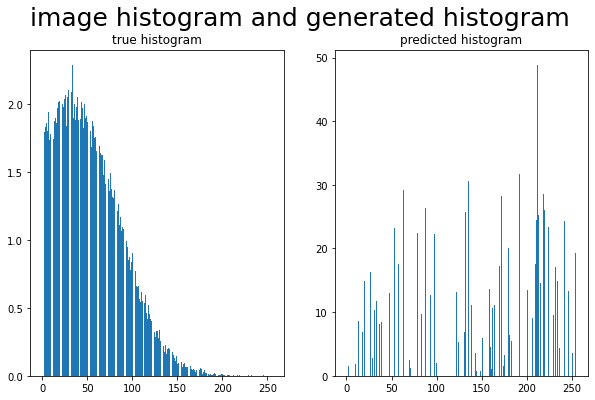

pred1 : 
 tensor([[0.0000e+00, 7.9798e-01, 1.8535e-01, 1.4971e+00, 1.0926e+00, 0.0000e+00,
         4.2269e-01, 1.1473e+00, 0.0000e+00, 0.0000e+00, 1.9496e+00, 0.0000e+00,
         4.7971e-01, 0.0000e+00, 5.5912e-01, 0.0000e+00, 0.0000e+00, 1.4662e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.8478e-02, 1.2159e+00,
         0.0000e+00, 1.2996e+00, 4.6501e-01, 1.1103e+00, 0.0000e+00, 2.7022e-01,
         2.8842e+00, 6.2308e-01, 0.0000e+00, 1.7234e+00, 0.0000e+00, 1.2493e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0632e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7702e+00, 1.1626e+00, 1.4268e+00,
         2.9684e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2792e+00, 0.0000e+00,
         1.4477e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 6.0601e-01, 1.2223e+00, 2.4038e+00, 0.0000e+00,
         0.0000e+00, 1.0692e-01, 2.4957e-01, 0.0000e+00, 0.0000e+00, 1.6598e+00,
         1.0988e+0

KeyboardInterrupt: ignored

In [490]:
model,loss,opt = create_Hist_model(256)

train_histmodel(model,1,50,50,50)

did 1


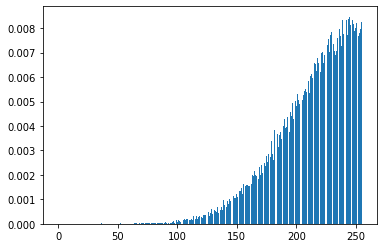

In [290]:
#plot_histogram_comparison(model,torch_gaussian_image(250,2))
img=torch_gaussian_image(250,50)
hist = histogram1d(np.array(img),bins=256,range=[0,256])/torch.numel(img)
plt.bar(list(range(256)), hist, align='center')
img = img.to("cuda:0")
print("did 1")

#plot_histogram_comparison(model,img)